# Unemployment and ruling party

This notebook shows how we can translate a research question into a testable hypothesis, find data and test it empirically.

### 1. Research Question:
Is the unemployment rate lower when Republicans are in office?


### 2. Testable hypothesis:
When the US has a Republican president, the unemployment rate tends to be higher than when a Democrat is in office.

In [1]:
# Load necessary libraries
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
%pip install fredapi
import fredapi

Note: you may need to restart the kernel to use updated packages.


### 3. Finding Data using FRED
We need to find data on **real stock market returns** and an indicator of the **president's party affiliation**.

In [2]:
# Import necessary libraries
from fredapi import Fred
import pandas as pd
import numpy as np

# Connect to FRED (replace with your actual API key if needed)
fred = Fred(api_key='223c2ce6e7e984e566530ca4a56b0c2f')

# Retrieve U-4 Unemployment Rate data from FRED
u4_data = fred.get_series(
    'U4RATE',
    observation_start='1994-01-01',
    observation_end='2025-08-01'
)

# Convert to DataFrame
df_u4 = pd.DataFrame(data=u4_data, columns=['U4_Unemployment_Rate'])
df_u4 = df_u4.rename_axis('Date').reset_index()

# Display first few rows
print("U-4 Unemployment Rate Data (First 5 Rows):")
print(df_u4.head(5))

# Optional: Calculate rolling averages or changes
# Example: 12-month rolling mean
df_u4['U4_Rolling_12M'] = df_u4['U4_Unemployment_Rate'].rolling(window=12).mean()

# Example: Month-over-month change
df_u4['U4_MoM_Change'] = df_u4['U4_Unemployment_Rate'].diff()

# Print summary stats
print("\nSummary Statistics:")
print(df_u4.describe())

U-4 Unemployment Rate Data (First 5 Rows):
        Date  U4_Unemployment_Rate
0 1994-01-01                   7.0
1 1994-02-01                   6.9
2 1994-03-01                   6.9
3 1994-04-01                   6.7
4 1994-05-01                   6.4

Summary Statistics:
                                Date  U4_Unemployment_Rate  U4_Rolling_12M  \
count                            380            380.000000      369.000000   
mean   2009-10-16 01:53:41.052631552              5.872895        5.881933   
min              1994-01-01 00:00:00              3.700000        3.766667   
25%              2001-11-23 12:00:00              4.500000        4.583333   
50%              2009-10-16 12:00:00              5.400000        5.441667   
75%              2017-09-08 12:00:00              6.400000        6.300000   
max              2025-08-01 00:00:00             15.100000       10.341667   
std                              NaN              1.894688        1.753335   

       U4_MoM_Change  


In [3]:
# Read in data files 
# GOP term flags
url = "https://github.com/llorracc/as.180.369/blob/main/materials/presidential-term-data/GOP_flag.csv?raw=true"
temp = pd.read_csv(url, dtype=str)
df_gop = pd.DataFrame(temp)

# Add a specific day (e.g., the first day of the month)
df_gop['Date'] = df_gop['Date'] + '.01'

# Convert to datetime
df_gop['Date'] = pd.to_datetime(df_gop['Date'], format='%Y.%m.%d', errors='coerce')
df_gop['Date'] = df_gop['Date'].dt.normalize()

# Check result
print(df_gop.head())

        Date GOP
0 1871-01-01   1
1 1871-02-01   1
2 1871-03-01   1
3 1871-04-01   1
4 1871-05-01   1


In [4]:
# Merge U-4 unemployment data with GOP flag data
df = pd.merge(df_u4, df_gop, on='Date', how='inner')

print(df.head(5))

        Date  U4_Unemployment_Rate  U4_Rolling_12M  U4_MoM_Change GOP
0 1994-01-01                   7.0             NaN            NaN   0
1 1994-01-01                   7.0             NaN            NaN   0
2 1994-02-01                   6.9             NaN           -0.1   0
3 1994-03-01                   6.9             NaN            0.0   0
4 1994-04-01                   6.7             NaN           -0.2   0


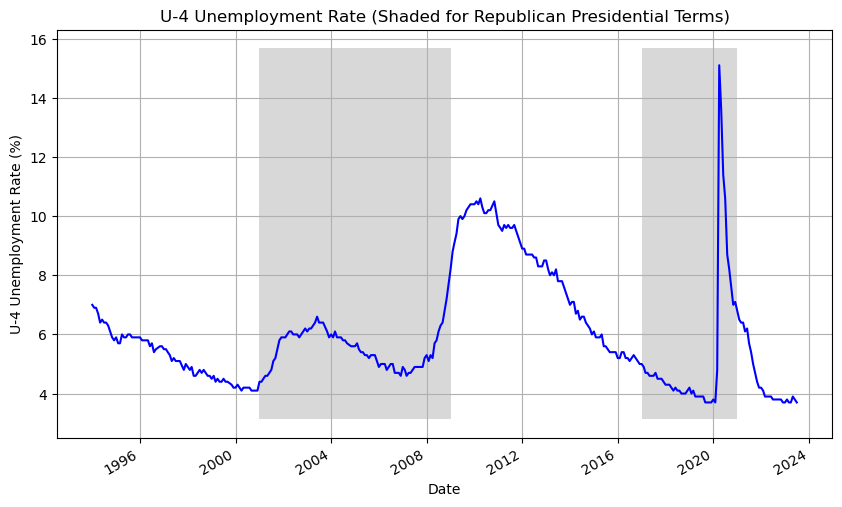

In [5]:
# Plot U-4 unemployment rate and shade GOP presidential terms

# Convenience function
def plot_series(ax, df, index='Date', cols=['U4_Unemployment_Rate'], area='GOP'):
    # Convert GOP flag to boolean
    df[area] = df[area].astype(int).astype(bool)
    # Set up an index based on date
    df = df.set_index(keys=index, drop=False)
    # Line plot
    df.plot(ax=ax, x=index, y=cols, color='blue', legend=False)
    # Extract limits
    y1, y2 = ax.get_ylim()
    # Shade GOP periods
    ax.fill_between(df[index].index, y1=y1, y2=y2, where=df[area], facecolor='grey', alpha=0.3)
    return ax

# Set up figure, axis
f, ax = plt.subplots(figsize=(10, 6))
plot_series(ax, df)
ax.set_title('U-4 Unemployment Rate (Shaded for Republican Presidential Terms)')
ax.set_xlabel('Date')
ax.set_ylabel('U-4 Unemployment Rate (%)')
ax.grid(True)
plt.show()


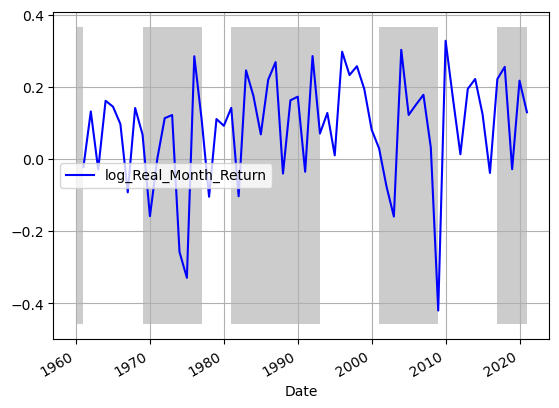

In [7]:
# Plot log total returns over time. Shade GOP presidential terms
# convenience function
def plot_series(ax, df, index='Date', cols=['log_Real_Month_Return'], area='GOP'):
    # convert area variable to boolean
    df[area] = df[area].astype(int).astype(bool)
    # set up an index based on date
    df = df.set_index(keys=index, drop=False)
    # line plot
    df.plot(ax=ax, x=index, y=cols, color='blue')
    # extract limits
    y1, y2 = ax.get_ylim()
    ax.fill_between(df[index].index, y1=y1, y2=y2, where=df[area], facecolor='grey', alpha=0.4)
    return ax

# set up figure, axis
f, ax = plt.subplots()
plot_series(ax, df)
ax.grid(True)
plt.show()


### 4. Testing hypothesis empirically with OLS

In [6]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Lag GOP flag by one month (pre-determined)
df['GOPlag'] = df['GOP'].shift()

# Drop any missing rows created by the lag
df_reg = df.dropna(subset=['U4_Unemployment_Rate', 'GOPlag'])

# Run OLS regression: unemployment rate on GOP (lagged)
results = smf.ols(formula='U4_Unemployment_Rate ~ GOPlag', data=df_reg).fit(cov_type='HC3')

print(results.summary())

                             OLS Regression Results                             
Dep. Variable:     U4_Unemployment_Rate   R-squared:                       0.046
Model:                              OLS   Adj. R-squared:                  0.044
Method:                   Least Squares   F-statistic:                     18.58
Date:                  Mon, 06 Oct 2025   Prob (F-statistic):           2.12e-05
Time:                          12:54:11   Log-Likelihood:                -721.66
No. Observations:                   354   AIC:                             1447.
Df Residuals:                       352   BIC:                             1455.
Df Model:                             1                                         
Covariance Type:                    HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.327

### 5. Conclusion
Based on the regression, unemployment (U-4 rate) is on average about 0.83 percentage points lower during Republican presidencies than Democratic ones. The difference is statistically significant, but the overall model explains little of the total variation in unemployment, and time dependence in the data suggests this relationship should be interpreted cautiously.